***


<h1 style = 'color:red'  align = 'center'>Prediction of the Energy consumption in London households</h1>  
<center> Oussama Smihrou </center>
<center> November 2021 </center>
***

# Introduction

Pour suivre la consommation d'énergie, le gouvernement britannique souhaite que les fournisseurs d'électricité installent des compteurs intelligents dans chaque foyer d'Angleterre, du Pays de Galles et d'Écosse (d'ici 2020).  Cette démarche s'inscrit dans le cadre d'une initiative lancée par l'Union européenne pour améliorer l'approvisionnement en énergie et répondre au réchauffement climatique. Dans ce sens, l'UK Power Networks a créé le Low Carbon London Project entre novembre 2011 et février 2014.  

Les bases de données utilisées proviennent de UK Power Networks, et rassemblent toutes les données de consommation énergétique de 5,5K ménages londoniens, un échantillon participant au Low Carbon London Project. Les mesures ont été effectuées toutes les demi-heures et les données des compteurs intelligents sont associées à la consommation d'électricité uniquement.

**Mon approche :**

1. Explorer le jeu de données de la consommation quotidienne moyenne, de la météo et des vacances à Londres.
2. Visualisation de la série temporelle actuelle


In [3]:
import warnings
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import os
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from pylab import rcParams
import seaborn as sns

from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
warnings.filterwarnings("ignore")

<ipython-input-3-a3ca540027be>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


ModuleNotFoundError: No module named 'tensorflow'

# 1. Importing datasets

The measurements made of the energy consumption of the houses have been organized in time groups where each time new houses have been added. So we start by centralizing all the data from all the houses at any given time.

## 1.1. Energy consumption dataset

In [2]:
# Combine all energy consumption measurement blocks
for block in range(0,112):
    df = pd.read_csv("daily_dataset/block_"+str(block)+".csv")
    df = df[['day','LCLid','energy_sum']]
    df.reset_index()
    df.to_csv("daily_dataset/new_block_"+str(block)+".csv")

final_file = open("energy_consumption.csv","w")
# Add the vector of columns to our energy.csv file
for line in open("daily_dataset/new_block_0.csv"):
    final_file.write(line)
# Centralization of all data from all blocks
for new_block in range(0,112):
    f = open("daily_dataset/new_block_"+str(new_block)+".csv")
    f.readline() # Be careful not to take the vector of columns already included in the file
    for line in f:
         final_file.write(line)
    f.close()
final_file.close()

In [1]:
energy = pd.read_csv('energy_consumption.csv')
energy.head()

NameError: name 'pd' is not defined

### Counting the evolution of the number of houses over time

In [4]:
# We group together all the days in which the measurement was made to have the number of houses
house_count = energy.groupby('day')[['LCLid']].nunique()

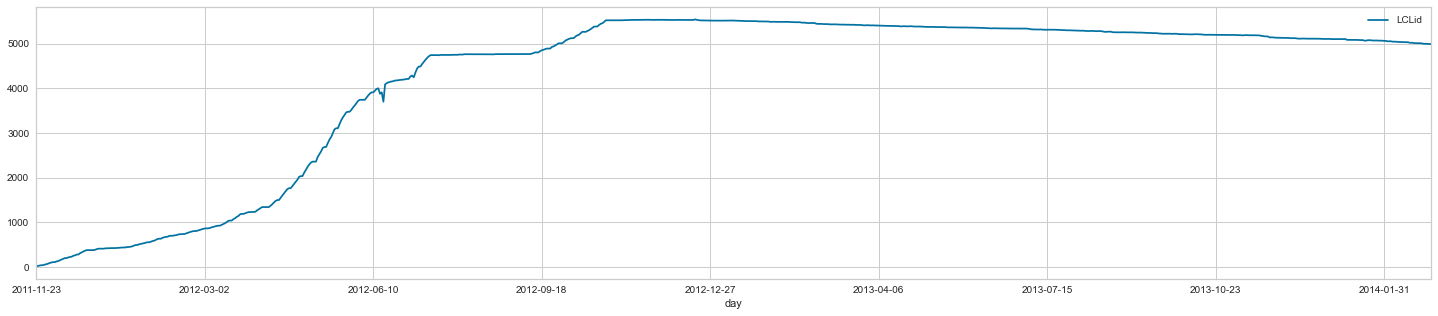

In [5]:
house_count.plot(figsize=(25,5))

**Nous constatons que le nombre de maisons participant à l'expérience augmente avant de dépasser la barre des 5000 vers la fin de l'année 2012**.

In [6]:
energy = energy.groupby('day')[['energy_sum']].sum()
energy = energy.merge(house_count, on = ['day'])
energy = energy.reset_index()

In [7]:
energy.head()

,day,energy_sum,LCLid
0,2011-11-23,90.385000,13
1,2011-11-24,213.412000,25
2,2011-11-25,303.993000,32
3,2011-11-26,420.976000,41
4,2011-11-27,444.883001,41


In [8]:
energy.day = pd.to_datetime(energy.day,format='%Y-%m-%d').dt.date

In [9]:
energy['avg_energy'] =  energy['energy_sum']/energy['LCLid']
print("Starting Point of Data at Day Level", min(energy.day))
print("Ending Point of Data at Day Level", max(energy.day))

Starting Point of Data at Day Level 2011-11-23
Ending Point of Data at Day Level 2014-02-28


In [10]:
energy.describe()

,energy_sum,LCLid,avg_energy
count,829.000000,829.000000,829.000000
mean,43535.325676,4234.539204,10.491862
std,20550.594031,1789.994799,1.902513
min,90.385000,13.000000,0.211766
25%,34665.436003,4084.000000,8.676955
50%,46641.160997,5138.000000,10.516983
75%,59755.616996,5369.000000,12.000690
max,84156.135002,5541.000000,15.964434


## 1.2. Weather dataset

In [11]:
weather = pd.read_csv('weather_daily_darksky.csv')
weather.head()

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,...,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,...,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,...,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,...,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25
4,8.22,2011-12-24 23:00:00,252,partly-cloudy-night,2.79,2011-12-24 07:00:00,0.37,4.46,1028.17,2011-12-24 07:00:00,...,7.93,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,-0.51,2011-12-24 23:00:00,2011-12-24 20:00:00,0.99


In [12]:
weather.describe()

,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
count,882.000000,882.000000,882.000000,881.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,881.000000,882.000000,882.000000,882.000000,882.000000,882.000000
mean,13.660113,195.702948,6.530034,0.477605,3.581803,1014.127540,12.723866,11.167143,0.781871,6.085045,12.929467,2.542565,7.709841,7.414161,13.542392,5.738039,0.500930
std,6.182744,89.340783,4.830875,0.193514,1.694007,11.073038,7.279168,2.466109,0.095348,6.031967,7.105426,1.832985,4.871004,4.888852,6.260196,6.048746,0.287022
min,-0.060000,0.000000,-7.840000,0.000000,0.200000,979.250000,-6.460000,1.480000,0.430000,-8.880000,-4.110000,0.000000,-5.640000,-5.640000,-0.810000,-8.880000,0.000000
25%,9.502500,120.500000,3.180000,0.350000,2.370000,1007.435000,7.032500,10.327500,0.720000,1.522500,7.332500,1.000000,3.990000,3.705000,9.212500,1.105000,0.260000
50%,12.625000,219.000000,6.380000,0.470000,3.440000,1014.615000,12.470000,11.970000,0.790000,5.315000,12.625000,2.000000,7.540000,7.100000,12.470000,4.885000,0.500000
75%,17.920000,255.000000,10.057500,0.600000,4.577500,1021.755000,17.910000,12.830000,0.860000,11.467500,17.920000,4.000000,11.467500,11.277500,17.910000,11.277500,0.750000
max,32.400000,359.000000,17.770000,1.000000,9.960000,1040.920000,32.420000,15.340000,0.980000,20.540000,32.420000,7.000000,20.540000,20.540000,32.400000,20.540000,0.990000


### Exploration of categorical variables

In [13]:
object_cols = [col for col in weather.columns if weather[col].dtype == "object"]

In [14]:
weather[object_cols].head()

,temperatureMaxTime,icon,temperatureMinTime,apparentTemperatureMinTime,precipType,apparentTemperatureHighTime,time,sunsetTime,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMaxTime,apparentTemperatureLowTime
0,2011-11-11 23:00:00,fog,2011-11-11 07:00:00,2011-11-11 07:00:00,rain,2011-11-11 19:00:00,2011-11-11 00:00:00,2011-11-11 16:19:21,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,2011-11-11 23:00:00,2011-11-11 19:00:00
1,2011-12-11 14:00:00,partly-cloudy-day,2011-12-11 01:00:00,2011-12-11 02:00:00,rain,2011-12-11 19:00:00,2011-12-11 00:00:00,2011-12-11 15:52:53,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,2011-12-11 20:00:00,2011-12-12 08:00:00
2,2011-12-27 02:00:00,partly-cloudy-day,2011-12-27 23:00:00,2011-12-27 22:00:00,rain,2011-12-27 14:00:00,2011-12-27 00:00:00,2011-12-27 15:57:56,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,2011-12-27 02:00:00,2011-12-28 00:00:00
3,2011-12-02 23:00:00,wind,2011-12-02 07:00:00,2011-12-02 07:00:00,rain,2011-12-02 12:00:00,2011-12-02 00:00:00,2011-12-02 15:56:17,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,2011-12-02 12:00:00,2011-12-02 19:00:00
4,2011-12-24 23:00:00,partly-cloudy-night,2011-12-24 07:00:00,2011-12-24 07:00:00,rain,2011-12-24 15:00:00,2011-12-24 00:00:00,2011-12-24 15:55:55,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,2011-12-24 23:00:00,2011-12-24 20:00:00


In [15]:
weather["precipType"].unique()

array(['rain', 'snow'], dtype=object)

**Since we are exploring the dark sky weather dataset, we choose to keep this variable because its cardinality is low (2) and may have an interesting predictive power.**

In [16]:
weather["icon"].unique()

array(['fog', 'partly-cloudy-day', 'wind', 'partly-cloudy-night',
       'clear-day', 'cloudy'], dtype=object)

**We also choose to keep this variable and use a Label Encoder by ordering the values in the icon column.**

In [17]:
weather[["summary"]].nunique()

summary    88
dtype: int64

In [18]:
weather["summary"].unique()[:10]

array(['Foggy until afternoon.', 'Partly cloudy throughout the day.',
       'Mostly cloudy throughout the day.',
       'Partly cloudy throughout the day and breezy overnight.',
       'Partly cloudy throughout the day and breezy in the morning.',
       'Foggy starting in the evening.',
       'Partly cloudy throughout the day and breezy starting in the evening.',
       'Foggy in the morning.', 'Partly cloudy until evening.',
       'Partly cloudy starting in the afternoon, continuing until evening.'],
      dtype=object)

**This variable has a very high cardinality and gives a lot of details by summarizing the data already present in the dataset, we will not keep it.**

In [19]:
# Je cherche les valeurs "null" sur mon dataset
for col in weather.columns :
    if list(pd.isnull(weather[col])) != [False for i in range(len(weather))] :
        print(weather[col][pd.isnull(weather[col]) == True])

846   NaN
Name: cloudCover, dtype: float64
846   NaN
Name: uvIndex, dtype: float64
846    NaN
Name: uvIndexTime, dtype: object


**Only one observation contains missing values for 3 variables, instead of using an algorithm to handle the missing values, we will just delete the observation in question.**

In [20]:
#To encode our weather variables, we overwrite the fit() function of the basic label encoder
class MyLabelEncoder(LabelEncoder):
    
    def fit(self, y):
        y = column_or_1d(y, warn=True)
        self.classes_ = pd.Series(y).unique()
        return self

In [21]:
le = MyLabelEncoder()
le.fit(['rain', 'snow'])
weather["precipType"] = le.transform(weather["precipType"])

In [22]:
le = MyLabelEncoder()
le.fit(['clear-day', 'partly-cloudy-day', 'partly-cloudy-night', 'cloudy', 'fog', 'wind'])
weather["icon"] = le.transform(weather["icon"])

In [23]:
object_cols = [col for col in weather.columns if weather[col].dtype == "object"]
weather['day']=  pd.to_datetime(weather['time']) # day is given as timestamp
weather['day']=  pd.to_datetime(weather['day'],format='%Y%m%d').dt.date
# selecting numeric variables
numeric_cols = list(set(weather.columns)-set(object_cols))
weather = weather[numeric_cols]
weather = weather.dropna()

## 1.3. Holidays dataset

In [24]:
holiday = pd.read_csv('uk_bank_holidays.csv')
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%Y-%m-%d').dt.date
holiday.head()

,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
4,2012-04-06,Spring bank holiday (substitute day)


# 2. Visualization of climate data

In [25]:
weather_energy =  energy.merge(weather,on='day')
weather_energy.head()

,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,uvIndex,apparentTemperatureMin,cloudCover,precipType,...,icon,temperatureHigh,temperatureMin,apparentTemperatureMax,apparentTemperatureHigh,moonPhase,dewPoint,apparentTemperatureLow,humidity,temperatureLow
0,2011-11-23,90.385000,13,6.952692,10.36,229,1.0,2.18,0.36,0,...,4,10.36,3.81,10.36,10.36,0.94,6.29,6.56,0.93,8.24
1,2011-11-24,213.412000,25,8.536480,12.93,204,1.0,7.01,0.41,0,...,2,12.93,8.56,12.93,12.93,0.97,8.56,7.30,0.89,9.71
2,2011-11-25,303.993000,32,9.499781,13.03,243,1.0,4.84,0.48,0,...,1,12.27,7.46,13.03,12.27,0.01,7.24,4.69,0.79,7.01
3,2011-11-26,420.976000,41,10.267707,12.96,237,1.0,4.69,0.44,0,...,5,12.96,7.01,12.96,12.96,0.05,6.96,11.59,0.81,11.59
4,2011-11-27,444.883001,41,10.850805,13.54,256,1.0,2.94,0.42,0,...,5,13.54,4.47,13.54,13.54,0.08,5.76,1.31,0.72,1.31


 **1. Temperature**

No handles with labels found to put in legend.
No handles with labels found to put in legend.


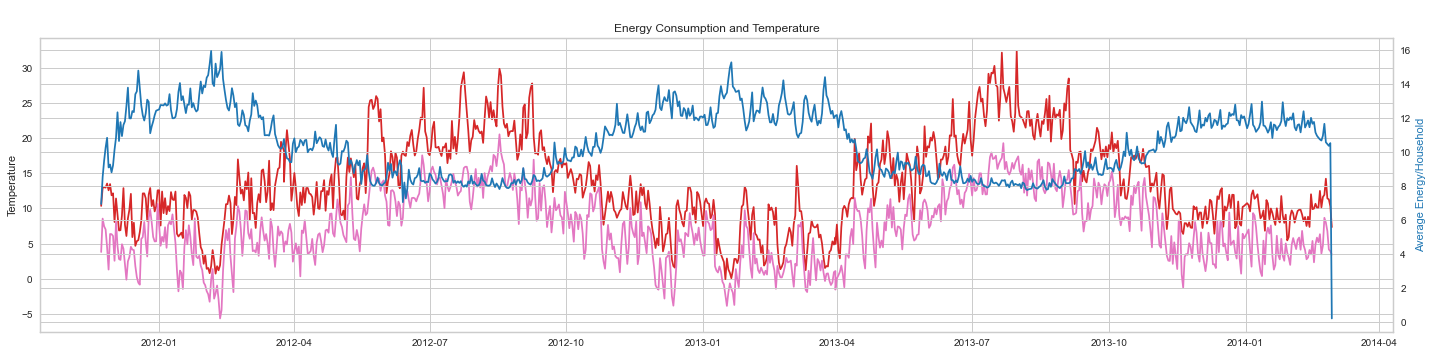

In [26]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color = 'tab:red')
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color = 'tab:pink')
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()

**2.  Humidity**


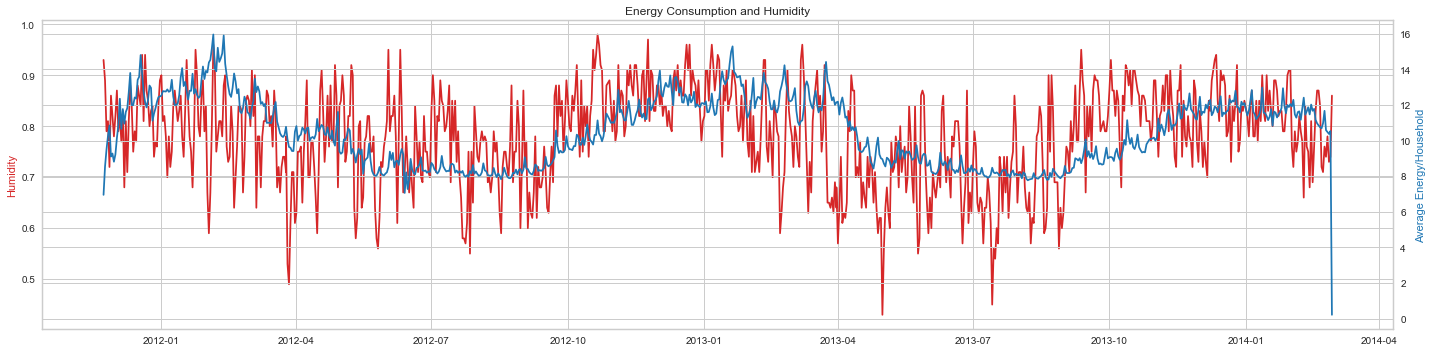

In [27]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.humidity, color = 'tab:red')
ax1.set_ylabel('Humidity',color = 'tab:red')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Humidity')
fig.tight_layout()
plt.show()

**3. Cloud Cover**

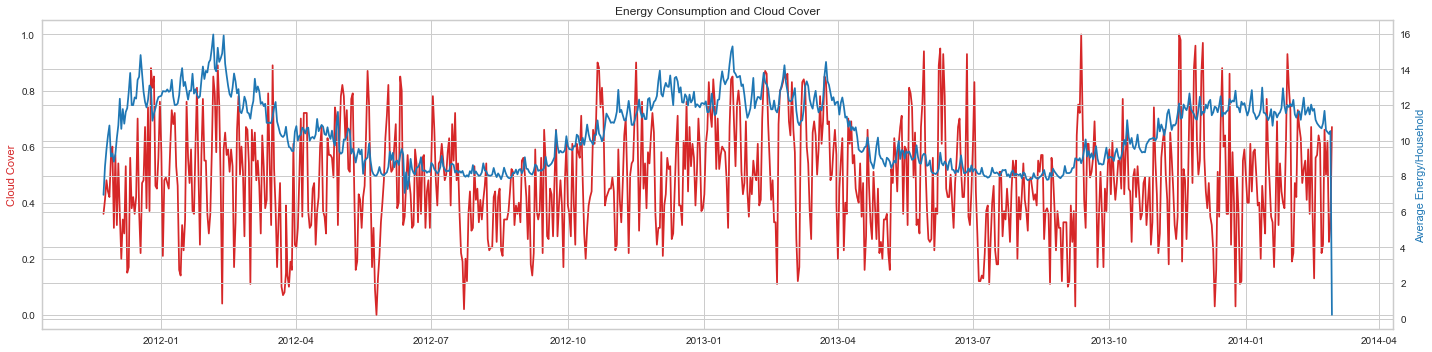

In [28]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.cloudCover, color = 'tab:red')
ax1.set_ylabel('Cloud Cover',color = 'tab:red')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Cloud Cover')
fig.tight_layout()
plt.show()

#### 4. precipType

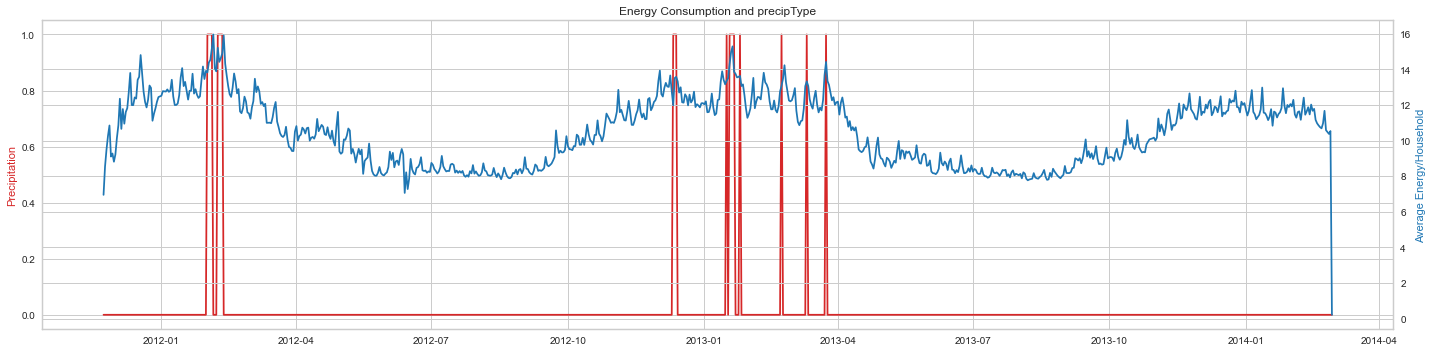

In [30]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.precipType, color = 'tab:red')
ax1.set_ylabel('Precipitation',color = 'tab:red')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and precipType')
fig.tight_layout()
plt.show()

# 3. Feature selection of climate variables

## Pearson correlation matrix

**We first select the columns that are not clearly correlated with each other, such as the maximum temperature and the apparent maximum temperature. We keep those which at first sight are decorrelated then make a second selection thanks to the Pearson correlation matrix.**

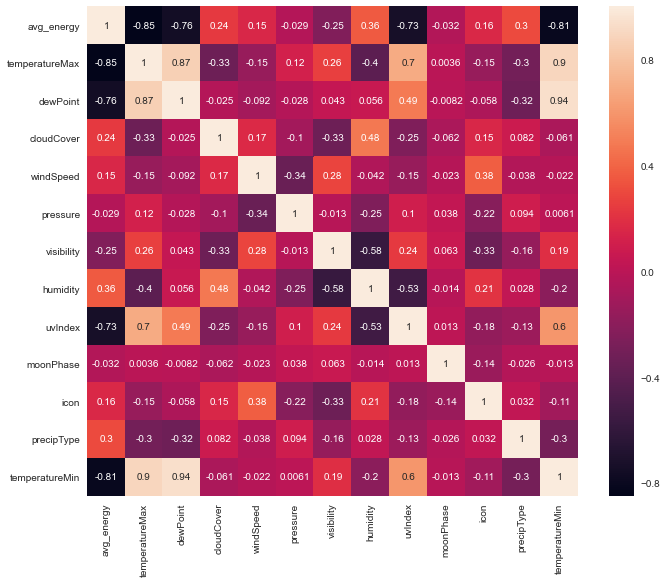

In [31]:
rcParams['figure.figsize'] = 11, 9
important_cols = ['avg_energy','temperatureMax','dewPoint', 'cloudCover', 'windSpeed','pressure', 'visibility', 'humidity','uvIndex', 'moonPhase','icon','precipType',"temperatureMin"]
cor_matrix = weather_energy[important_cols].corr()
# Correlation entre les variables en utilisant la loi de Pearson
sns.heatmap(cor_matrix, 
            xticklabels=cor_matrix.columns.values,
            yticklabels=cor_matrix.columns.values, annot=True)

# 4. Creation of a new variable from a KMeans clustering

**Through the above correlation matrix, we select variables that are uncorrelated with each other and correlated with our target avg_energy to build a variable that we will use in our LSTM named weather_cluster.**

In [32]:
#Scaling
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(weather_energy[['temperatureMax',"humidity","precipType","cloudCover"]])

**We use the Elbow method which is a heuristic to find the optimal number of clusters noted here k, the idea is not to go towards a cross validation considered too advanced for the size of the project.**

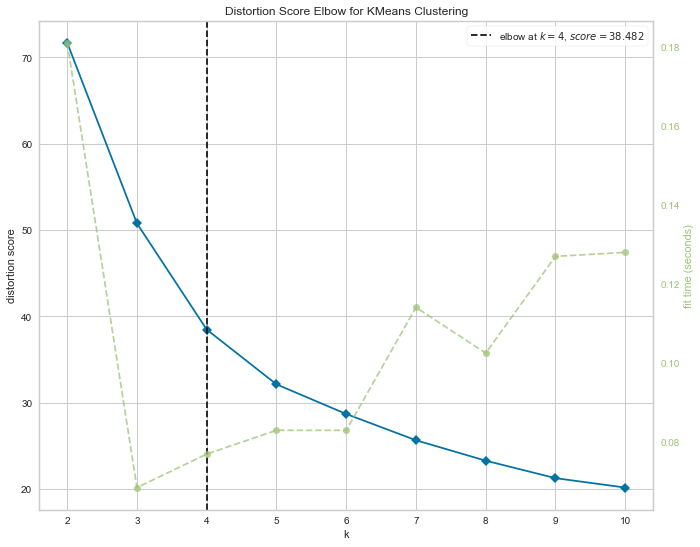

In [34]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(weather_scaled)        
visualizer.show()        

In [35]:
kmeans = KMeans(n_clusters=4, max_iter=600, algorithm = 'auto')
kmeans.fit(weather_scaled)
weather_energy['weather_cluster'] = kmeans.labels_

## Cluster visualization

**In order to visualize the clusters obtained by Kmeans, we perform a principal component analysis to reduce the dimension of the data on which the clustering was done. Indeed, a visualization cannot admit more than 3 variables and we have 4.**

In [36]:
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(weather_scaled)

In [37]:
principal_data = pd.DataFrame(principal_components, columns = ['Composante principale 1', 'Composante principale 2'])
principal_data.head()

,Composante principale 1,Composante principale 2
0,0.126572,0.019939
1,0.070668,-0.026569
2,0.016939,-0.008958
3,0.013451,0.001249
4,-0.092475,0.049975


In [38]:
principal_data['Cluster'] = kmeans.labels_

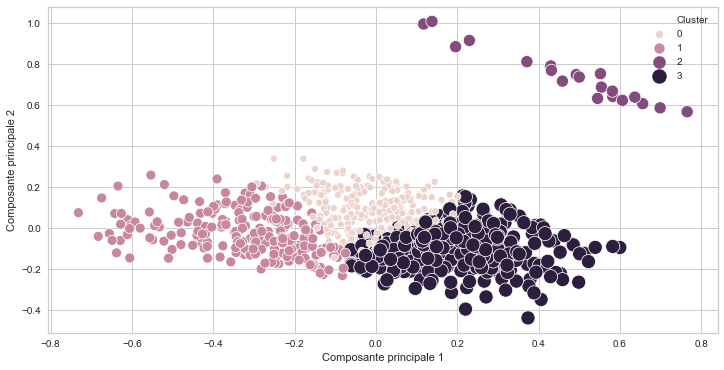

In [39]:
figure = plt.figure(figsize = (12, 6))
sns.scatterplot(x = 'Composante principale 1', y = 'Composante principale 2', 
                hue = 'Cluster', size = 'Cluster', sizes = (50, 200),
                data = principal_data)
plt.show()

## 5. LSTM implementation

### 5.1. Train & Test datasets

In [40]:
weather_energy = weather_energy.merge(holiday, left_on = 'day',right_on = 'Bank holidays',how = 'left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(),0,1)

In [41]:
weather_energy['Year'] = pd.DatetimeIndex(weather_energy['day']).year  
weather_energy['Month'] = pd.DatetimeIndex(weather_energy['day']).month
weather_energy.set_index(['day'],inplace=True)

In [42]:
weather_energy.drop(weather_energy.tail(1).index,inplace=True)
X = weather_energy[['weather_cluster','holiday_ind']]
y = weather_energy['avg_energy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 0, shuffle = False)

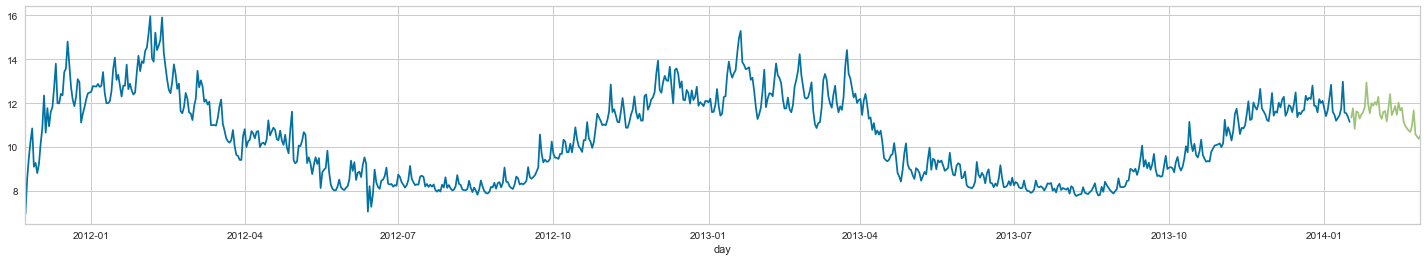

In [43]:
y_train.plot(figsize=(25,4))
y_test.plot(figsize=(25,4))

### 5.2. LSTM model

In [44]:
dataframe = weather_energy.loc[:,'avg_energy']
energy_dataset = dataframe.values
energy_dataset = energy_dataset.astype('float32')

In [45]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # la séquence d'entrée, on prendra une semaine (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # la séquence de sortie, on prendra un jour (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [46]:
reframed = series_to_supervised(energy_dataset, 7,1)
reframed.head(3)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,6.952693,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513
8,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707
9,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707,10.145910


In [47]:
reframed['weather_cluster'] = weather_energy.weather_cluster.values[7:]
reframed['holiday_ind']= weather_energy.holiday_ind.values[7:]

In [48]:
reframed = reframed.reindex(['weather_cluster', 'holiday_ind','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
reframed = reframed.values

**5.2.1. Normalization**

In [49]:
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

In [50]:
reframed = pd.DataFrame(reframed)
reframed.columns = ['weather_cluster', 'holiday_ind','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)']
reframed.head()

,weather_cluster,holiday_ind,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,0.0,0.0,0.000000,0.166102,0.274247,0.360458,0.425920,0.229746,0.248998,0.197203
1,1.0,0.0,0.175747,0.274247,0.360458,0.425920,0.229746,0.248998,0.197203,0.243703
2,0.0,0.0,0.282641,0.360458,0.425920,0.229746,0.248998,0.197203,0.243703,0.346785
3,1.0,0.0,0.367855,0.425920,0.229746,0.248998,0.197203,0.243703,0.346785,0.427194
4,0.0,0.0,0.432559,0.229746,0.248998,0.197203,0.243703,0.346785,0.427194,0.594438


In [51]:
X = reframed[['weather_cluster', 'holiday_ind','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)',
              'var1(t-3)','var1(t-2)', 'var1(t-1)']]
y = reframed['var1(t)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle = False)

In [52]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [53]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(656, 1, 9) (656,) (164, 1, 9) (164,)


**5.2.2. Modelling**


Epoch 1/30
 - 1s - loss: 0.0551
Epoch 2/30
 - 0s - loss: 0.0100
Epoch 3/30
 - 0s - loss: 0.0081
Epoch 4/30
 - 0s - loss: 0.0068
Epoch 5/30
 - 0s - loss: 0.0060
Epoch 6/30
 - 0s - loss: 0.0055
Epoch 7/30
 - 0s - loss: 0.0052
Epoch 8/30
 - 0s - loss: 0.0050
Epoch 9/30
 - 0s - loss: 0.0049
Epoch 10/30
 - 0s - loss: 0.0048
Epoch 11/30
 - 0s - loss: 0.0048
Epoch 12/30
 - 0s - loss: 0.0047
Epoch 13/30
 - 0s - loss: 0.0047
Epoch 14/30
 - 0s - loss: 0.0046
Epoch 15/30
 - 0s - loss: 0.0046
Epoch 16/30
 - 0s - loss: 0.0045
Epoch 17/30
 - 0s - loss: 0.0045
Epoch 18/30
 - 0s - loss: 0.0044
Epoch 19/30
 - 0s - loss: 0.0044
Epoch 20/30
 - 0s - loss: 0.0044
Epoch 21/30
 - 0s - loss: 0.0043
Epoch 22/30
 - 0s - loss: 0.0043
Epoch 23/30
 - 0s - loss: 0.0042
Epoch 24/30
 - 0s - loss: 0.0042
Epoch 25/30
 - 0s - loss: 0.0042
Epoch 26/30
 - 0s - loss: 0.0041
Epoch 27/30
 - 0s - loss: 0.0041
Epoch 28/30
 - 0s - loss: 0.0040
Epoch 29/30
 - 0s - loss: 0.0040
Epoch 30/30
 - 0s - loss: 0.0040


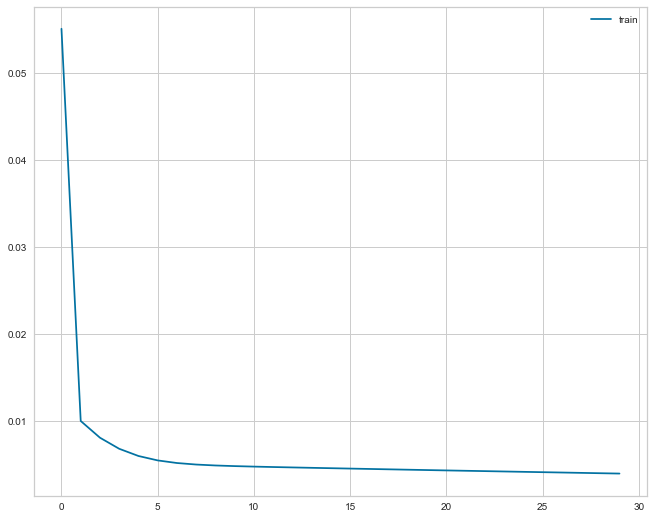

In [54]:
# Modélisation
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adamax')
# Fitting
history = model.fit(X_train, y_train, epochs = 30, batch_size=10, verbose=2, shuffle=False)
# History
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

**5.2.3. Prediction**

In [55]:
y_pred = model.predict(X_test)

In [56]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

In [57]:
# Fonction inverse du scaling pour les prédictions
inv_yhat = np.concatenate((X_test, y_pred), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [58]:
# Fonction inverse du scaling pour les données réelles
y_test = np.array(y_test).reshape((len(y_test), 1))
inv_y = np.concatenate((X_test, y_test), axis=1)
inv_y = scaler.inverse_transform(inv_y)

**5.2.4. Performance evaluation**

In [59]:
actual = [i[9] for i in inv_y] 
predicted = [i[9] for i in inv_yhat] 

rmse = math.sqrt(mean_squared_error(actual, predicted))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.534


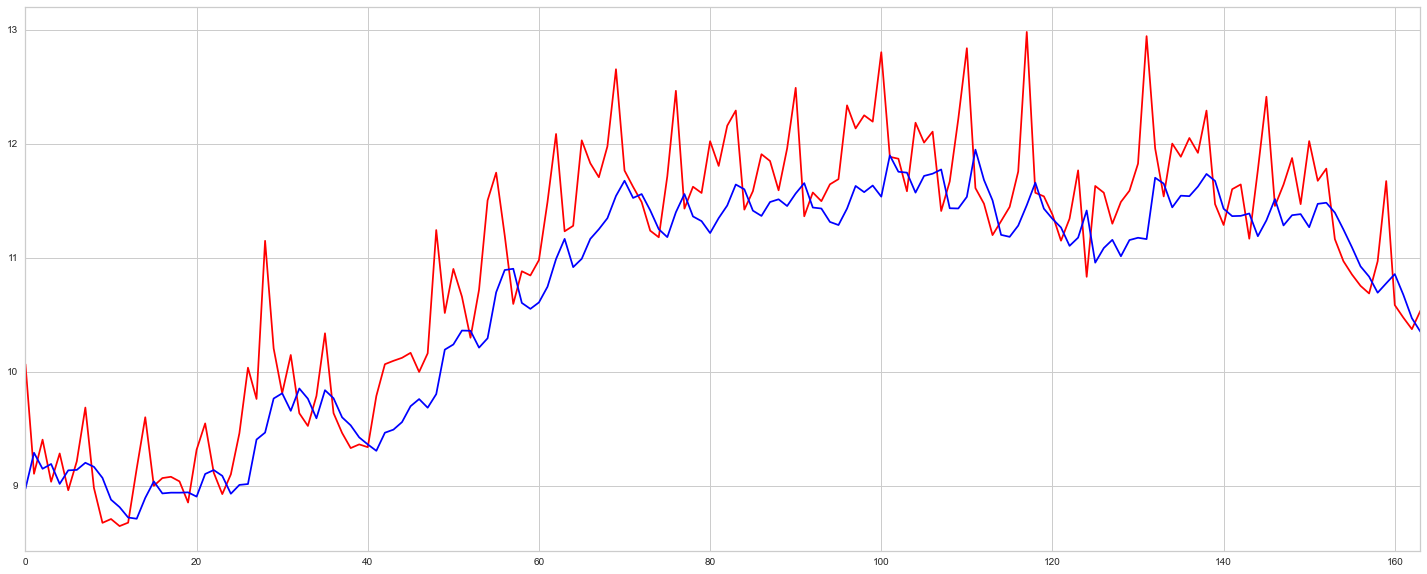

In [60]:
predicted_lstm = pd.DataFrame({'predicted':predicted,'avg_energy':actual})
predicted_lstm['avg_energy'].plot(figsize=(25,10),color = 'red')
predicted_lstm['predicted'].plot(color = 'blue')
plt.show()